## Imports and settings

In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import wandb
import os
import glob
import torch.nn.functional as F

In [105]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [106]:
wandb.init(project="deeplens-lens-finding", entity="samkitshah1262-warner-bros-discovery", reinit=True)

In [107]:
class Config:
    SEED = 1
    BATCH_SIZE = 64
    EPOCHS = 150
    LEARNING_RATE = 1e-4
    NUM_CLASSES = 3
    IMG_SIZE = (150, 150)
    USE_SAVED_MODEL = False
    CKPT_PATH = "./model_weights.pth"

config = Config()
train_lens_dir = './lens-finding-test/train_lenses/'
train_nonlens_dir = './lens-finding-test/train_nonlenses/'
test_lens_dir = './lens-finding-test/test_lenses/'
test_nonlens_dir = './lens-finding-test/test_nonlenses/'

torch.manual_seed(config.SEED)
np.random.seed(config.SEED)

In [108]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")

In [109]:
# import gdown

# url = "https://drive.google.com/uc?id=12p4fMT2HmiDtu-PL_VNiByXxZnaBle84"
# output = "dataset.zip"
# gdown.download(url, output)
# !unzip -q dataset.zip

## Data Loading and Processing

In [110]:
class LensDataset(Dataset):
    def __init__(self, lens_dir, nonlens_dir, transform=None):
        """
        lens_dir: directory with npy files of lensed galaxies (label 1)
        nonlens_dir: directory with npy files of non-lensed galaxies (label 0)
        """
        self.transform = transform
        
        self.lens_files = glob.glob(os.path.join(lens_dir, '*.npy'))
        self.nonlens_files = glob.glob(os.path.join(nonlens_dir, '*.npy'))
        
        self.data = [(f, 1) for f in self.lens_files] + [(f, 0) for f in self.nonlens_files]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        filepath, label = self.data[idx]
        image = np.load(filepath).astype(np.float32)
        if self.transform:
            image = self.transform(image)
        image = torch.tensor(image)
        return image, torch.tensor(label, dtype=torch.float32)

def get_sampler(dataset):
    labels = [label.item() for _, label in dataset]
    class_sample_count = np.array([sum(np.array(labels)==t) for t in [0, 1]])

    print('Class counts:', class_sample_count)
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(label)] for label in labels])
    samples_weight = torch.from_numpy(samples_weight).float()
    sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)
    print('Class weights:', weight)
    
    return sampler

def load_data():


    train_dataset = LensDataset(train_lens_dir, train_nonlens_dir)
    test_dataset = LensDataset(test_lens_dir, test_nonlens_dir)
    
    train_sampler = get_sampler(train_dataset)


    train_loader = DataLoader(train_dataset, batch_size=256, sampler=train_sampler,pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False,pin_memory=True)
    return train_loader, test_loader


In [111]:
train_loader, val_loader = load_data()

Class counts: [28675  1730]
Class weights: [3.48735833e-05 5.78034682e-04]


## Model

In [112]:
class CNN(nn.Module):
    def __init__(self, dropout_prob=0.3):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout_prob/4),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout_prob/2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout_prob),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.AdaptiveAvgPool2d((4, 4))
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_prob),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_prob),
            
            nn.Linear(512, 1)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## Trainer and Validator

In [116]:
def evaluate(model, loader, criterion):
    model.eval()
    loss = 0
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            
            probs = torch.sigmoid(outputs).cpu()
            all_probs.append(probs)
            all_labels.append(labels.cpu())
    
    all_probs = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()
    auc = roc_auc_score(all_labels, all_probs)
    
    return loss/len(loader), auc, all_labels, all_probs

In [119]:
def train_model(model, train_loader, val_loader):
    model.to(device)
    pos_weight = torch.tensor([17.0]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)
    best_auc = 0

    for epoch in range(20):
        model.train()
        train_loss = 0
        all_preds = []
        all_labels = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            probs = torch.sigmoid(outputs).detach().cpu()
            all_preds.append(probs)
            all_labels.append(labels.cpu())
        train_preds = torch.cat(all_preds).numpy()
        train_labels = torch.cat(all_labels).numpy()
        train_auc = roc_auc_score(train_labels, train_preds)
        val_loss, val_auc, val_labels, val_probs = evaluate(model, val_loader, criterion)
        scheduler.step(val_auc)
        fpr, tpr, thresholds = roc_curve(val_labels, val_probs)

        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss/len(train_loader),
            "train_auc": train_auc,
            "val_loss": val_loss,
            "val_auc": val_auc,
            "roc_curve": wandb.plot.line_series(
                xs=[fpr],
                ys=[tpr],
                keys=['ROC'],
                title="ROC Curve",
                xname="False Positive Rate"
            ),
        })
        
        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), config.CKPT_PATH)

        print(f'Epoch {epoch+1}/{config.EPOCHS}')
        print(f'Train Loss: {train_loss/len(train_loader):.4f} | Train AUC: {train_auc:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f}')

    model.load_state_dict(torch.load(config.CKPT_PATH))
    return model


In [120]:
model = CNN()
model = train_model(model, train_loader, val_loader)

Epoch 1/150
Train Loss: 1.3799 | Train AUC: 0.8975
Val Loss: 0.9854 | Val AUC: 0.9255
Epoch 2/150
Train Loss: 0.9052 | Train AUC: 0.9437
Val Loss: 0.6869 | Val AUC: 0.9465
Epoch 3/150
Train Loss: 0.7270 | Train AUC: 0.9579
Val Loss: 0.4931 | Val AUC: 0.9551
Epoch 4/150
Train Loss: 0.6620 | Train AUC: 0.9631
Val Loss: 0.5827 | Val AUC: 0.9550
Epoch 5/150
Train Loss: 0.5746 | Train AUC: 0.9709
Val Loss: 0.4231 | Val AUC: 0.9598
Epoch 6/150
Train Loss: 0.5263 | Train AUC: 0.9736
Val Loss: 0.3955 | Val AUC: 0.9625
Epoch 7/150
Train Loss: 0.4550 | Train AUC: 0.9783
Val Loss: 0.3906 | Val AUC: 0.9636
Epoch 8/150
Train Loss: 0.4336 | Train AUC: 0.9793
Val Loss: 0.3593 | Val AUC: 0.9639
Epoch 9/150
Train Loss: 0.3975 | Train AUC: 0.9813
Val Loss: 0.3221 | Val AUC: 0.9649
Epoch 10/150
Train Loss: 0.3771 | Train AUC: 0.9835
Val Loss: 0.2767 | Val AUC: 0.9652
Epoch 11/150
Train Loss: 0.3439 | Train AUC: 0.9845
Val Loss: 0.2926 | Val AUC: 0.9657
Epoch 12/150
Train Loss: 0.3287 | Train AUC: 0.9856


In [131]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def log_confusion_matrix(labels, probs, class_names, threshold=0.5):
    """
    Log confusion matrix to wandb and return matplotlib figure
    """
    preds = (probs >= threshold).astype(int)
    # print("labels", labels[0])
    # print("preds", preds[0])
    cm = confusion_matrix(labels, preds)

    fig = plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    wandb.log({"confusion_matrix": wandb.Image(fig)})
    plt.close(fig)
    return fig


In [123]:
pos_weight = torch.tensor([17.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
final = CNN()
final.load_state_dict(torch.load(config.CKPT_PATH))
val_loss, val_auc, val_labels, val_probs = evaluate(model, val_loader, criterion)

labels [1.]
preds [0]


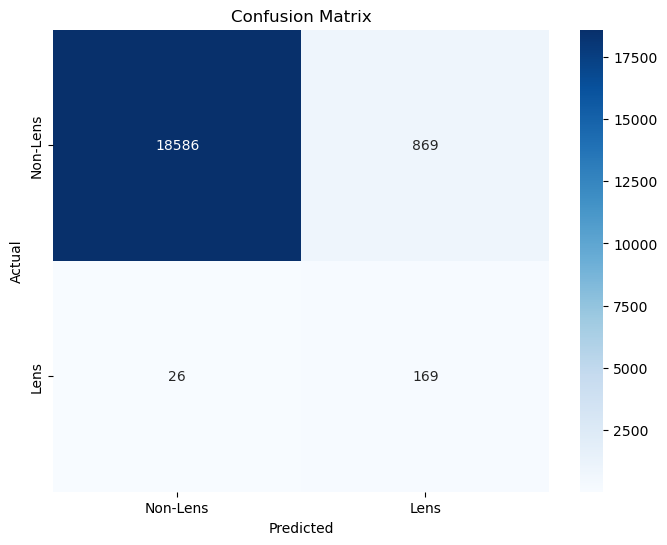

In [132]:
log_confusion_matrix(val_labels, val_probs, ["Non-Lens", "Lens"])